In [6]:
!ls /mnt/storage/charan/data/

stu_dset.pkl


In [318]:
import os
import random
import datetime
import argparse
import numpy as np
import medpy.metric.binary as mmb
from tqdm import tqdm
from model.unetdsbn import Unet2D
from utils.loss import dice_loss1
from datasets.dataset import Dataset, ToTensor, CreateOnehotLabel
from test_utils import get_bn_statis, cal_distance
import torch
import torchvision.transforms as tfs
from torch import optim
from torch.optim import Adam
from torch.backends import cudnn
from torch.nn import DataParallel
from torch.utils.data import DataLoader
import logging
import copy
import time
import torch.nn as nn
import matplotlib.pyplot as plt
import pickle as pkl
from monai.transforms import(
    AsDiscrete,
    AsDiscreted,
    Compose,
    LoadImaged,
    RandFlipd,
    EnsureChannelFirstd,
    RandCropByPosNegLabeld,
    Spacingd,
    RandShiftIntensityd,
    RandGaussianSmoothd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
    RandAffined,
    SpatialPadd,
    LabelToMaskd,
    SqueezeDimd,
    SqueezeDim,
    SpatialPad,
    Resized,
    Activations,
    RandRotate90d,
    SpatialCropd,
   
)
import nibabel as nib
from monai.data import Dataset, NibabelReader
from monai.data import DataLoader, decollate_batch
from monai.inferers import SliceInferer
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric

In [298]:
with open('/mnt/storage/ramon_data_curations/tutorials/segmentation_tutorial/kits23_dset.pkl','rb') as f: 
    tr, val, ts = pkl.load(f)


In [321]:
with open('/mnt/storage/charan/data/stu_dset.pkl','rb') as f: 
    tr, val, ts = pkl.load(f)

In [320]:
np.unique(nib.load(tr[10]["label"]).get_fdata()), np.unique(nib.load(tr[21]["label"]).get_fdata())

(array([0., 1.]), array([0., 1.]))

In [324]:
from monai.transforms import (
    Compose,
    LoadImaged,
    EnsureChannelFirstd,
    ScaleIntensityRanged,
    SplitDimd,
    LabelToMaskd,
    Rotate90d
)
from monai.data import NibabelReader
from monai.transforms import Transposed

# Define the transformation pipeline
val_transforms = Compose([
    # Load the 3D volume
    LoadImaged(
        keys=["image", "label"], 
        reader=NibabelReader, 
        image_only=False
    ),
    
    # Ensure channel-first format (NCHWD)
    EnsureChannelFirstd(
        keys=["image", "label"]
    ),



#   Transposed(keys=["image", "label"], indices=[0, 3, 1, 2]),  
    
    # Now rotate on the proper spatial dimensions
    Rotate90d(
        keys=["image", "label"],
        k=3,
        spatial_axes=(0, 1)
    ),
    
    # # Move channels back to the end
    # Transposed(keys=["image", "label"], indices=[0, 2, 3, 1])
    
    # # Convert label to binary mask if needed
    LabelToMaskd(
        keys="label",
        select_labels=[1],
        merge_channels=False
    ),
    
      ScaleIntensityRanged(
        keys="image",
        a_min=-100,    # minimum input intensity to clip
        a_max=300,     # maximum input intensity to clip
        b_min=-1,      # minimum output intensity
        b_max=1,       # maximum output intensity
        clip=True      # clip values outside the range
    ),

    # Orientationd(keys=["image", "label"], axcodes="RAS"),
    
    ])
    
    # Scale intensity of the image

    
val_forwardpass_transforms = Compose([
    #     LoadImaged(
    #     keys=["image", "label"], 
    #     reader=NibabelReader, 
    #     image_only=False
    # ),
    SplitDimd(
        keys=["image", "label"],
        dim=1,         # split along z-axis (dim 3 because: N,C,H,W,D)
        keepdim=False, # remove the split dimension
        list_output=True
    ),
    # Transposed(keys=["image", "label"], indices=[1, 0, 2, 3]),
    # SqueezeDim(dim=3)
        ScaleIntensityRanged(
        keys="image",
        a_min=-100,    # minimum input intensity to clip
        a_max=300,     # maximum input intensity to clip
        b_min=-1,      # minimum output intensity
        b_max=1,       # maximum output intensity
        clip=True      # clip values outside the range
    ),
])

In [300]:
x = val_transforms(tr[0])

In [301]:
x["image"].shape

torch.Size([1, 106, 512, 512])

In [245]:
len(val)

48

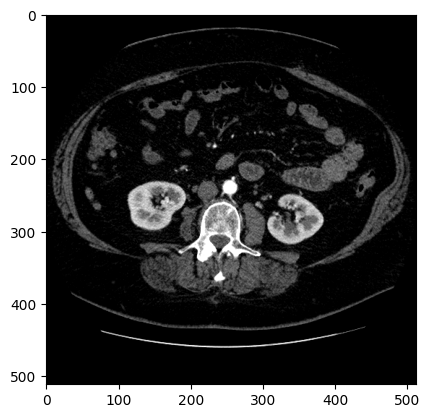

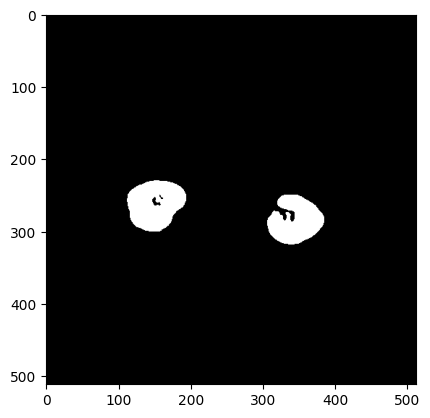

In [303]:
plt.imshow(x["image"][0][70,:,:], cmap = "gray")
plt.show()
plt.imshow(x["label"][0][70,:,:], cmap = "gray")
plt.show()

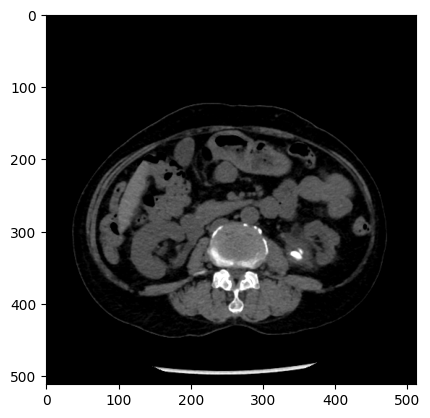

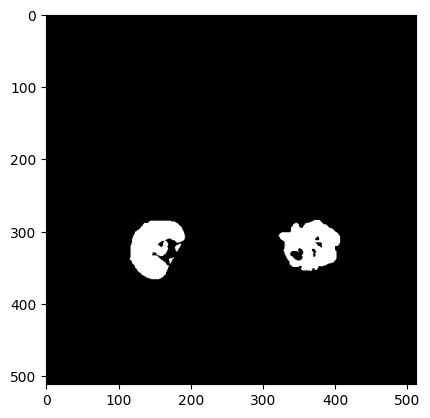

In [42]:
plt.imshow(x["image"][0][:,:,92], cmap = "gray")
plt.show()
plt.imshow(x["label"][0][:,:,92], cmap = "gray")
plt.show()

In [92]:
len(val)

31

In [325]:
val.pop(4)

{'image': '/mnt/storage/ramon_data_curations/STU_noncon_dataset/wd0232_ps_image.nii.gz',
 'label': '/mnt/storage/ramon_data_curations/STU_noncon_dataset/wd0232_ps_mask.nii.gz'}

In [326]:
val_dataset = Dataset(val, transform = val_transforms)

val_loader = DataLoader(val_dataset, batch_size=1, shuffle = False, num_workers=4)

In [ ]:
# test = val_transforms(val[0])

In [ ]:
# mod_test = val_forwardpass_transforms(test)

In [ ]:
# val[0]

In [ ]:
# test["image"].shape

In [ ]:
# test["image"][0].shape
# image_slices = [slice_dict['image'] for slice_dict in test]  # List of image tensors

# # Stack the list of image tensors along the first dimension to get a tensor of shape [88, 1, 512, 512]
# stacked_image_tensor = torch.stack(image_slices, dim=0)

# stacked_image_tensor.shape

In [327]:
#load the trained model

model = Unet2D(num_classes=2, norm='dsbn', num_domains=2)
device = torch.device("cuda:2")
model.load_state_dict(torch.load("best_model_DN.pth")["model_dict"])

# model = nn.DataParallel(model, device_ids=["cuda:0", "cuda:1"])
model.to(device)

/tmp/ipykernel_775268/3229827828.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model_DN.pth")["model_dict"])


Unet2D(
  (convd1): ConvD(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): DomainSpecificBatchNorm2d(
      (bns): ModuleList(
        (0-1): 2 x BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): DomainSpecificBatchNorm2d(
      (bns): ModuleList(
        (0-1): 2 x BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (conv3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn3): DomainSpecificBatchNorm2d(
      (bns): ModuleList(
        (0-1): 2 x BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
  )
  (convd2): ConvD(
    (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): DomainSpecificBatchNorm2d(
      (bns): ModuleList(
        (0-1): 2 x BatchNorm2d(32, eps=1e-05

In [328]:
means_list = []
vars_list = []

for i in range(2):
    means, vars = get_bn_statis(model, i)
    means_list.append(means)
    vars_list.append(vars)

In [314]:
def predictor_wrapper1(data):

    B, C, D, H, W = data.shape
    data = data.reshape(-1, C, H, W)  

    domain_label = domain_id * torch.ones(data.shape[0], dtype=torch.long, device=data.device)
    
    output = model_copy(data, domain_label=domain_label)
   
    OUT_C = output.shape[1]
    output = output.reshape(B, OUT_C, D, H, W)
    
    return output


def predictor_wrapper2(data):

    B, C, D, H, W = data.shape
    data = data.reshape(-1, C, H, W)  

    domain_label = selected_domain * torch.ones( data.shape[0], dtype=torch.long, device=data.device)

    output = model(data, domain_label=domain_label)
    
    OUT_C = output.shape[1]
    output = output.reshape(B, OUT_C, D, H, W)
    
    return output


In [329]:

def predictor_wrapper1(data):
   
    # print("data before reshape:",data.shape)
    B, C, D, H, W = data.shape
    data = data.reshape(-1, C, D, H) 
    # print("data after reshape:",data.shape)
    # Adjust domain label for the new batch size
    domain_label = domain_id * torch.ones(data.shape[0], dtype=torch.long, device=data.device)
    
    # Pass to model
    output = model_copy(data, domain_label=domain_label)
    # print("output shape before reshape:", output.shape)
    # Reshape output back to 5D if needed
    # If your model output shape is [B*D, OUT_C, H, W]
    OUT_C = output.shape[1]
    output = output.reshape(B, OUT_C, D, H, W)
    # print("output shape from predictor wrapper:", output.shape)
    
    return output




def predictor_wrapper2(data):
    # data is your input image/slice
   # Get batch size from the input data
    # print("selcted domain from predictor_wrapper1:",selected_domain )
    
    
    B, C, D, H, W = data.shape
    data = data.reshape(-1, C, D, H)   # Combine batch and depth dimensions
    print("selcted domain:",selected_domain)
    # print("data shape from predictor_wrapper2:", data.shape)
    # Create domain label tensor for the current batch
    domain_label = selected_domain * torch.ones( data.shape[0], dtype=torch.long, device=data.device)

    output = model(data, domain_label=domain_label)
    
    # Reshape output back to 5D if needed
    # If your model output shape is [B*D, OUT_C, H, W]
    OUT_C = output.shape[1]
    output = output.reshape(B, OUT_C, D, H, W)
    
    # Pass both arguments to your model
    return output



In [310]:
# for i in range(len(val)):
#     img = nib.load(val[i]["image"]).get_fdata()
#     lbl = nib.load(val[i]["label"]).get_fdata()
#     print(img.shape, lbl.shape)

In [331]:

dice_metric = DiceMetric(include_background=False, reduction="mean")

model_copy = copy.deepcopy(model)
model_copy.train()   

with torch.no_grad():
    for idx, (batch) in enumerate(val_loader):
        model.train()      

        sample_data = batch['image'].to(device)
        # print("image shape:", sample_data.shape)

        mask = batch['label']
        
        dis = 99999999
        best_out = None
        for domain_id in range(2):

            roi_size = (512, 512, 1)  

            output = sliding_window_inference(
                inputs=sample_data,  
                roi_size=roi_size,       
                sw_batch_size= 16,          
                predictor=predictor_wrapper1, 
                sw_device="cuda:2", 
                device="cpu" 
            )

            # print("output_forward_pass:",output.shape)
            means, vars = get_bn_statis(model_copy, domain_id)
            new_dis = cal_distance(means, means_list[domain_id], vars, vars_list[domain_id])

            if new_dis < dis:
                selected_domain = domain_id
                dis = new_dis


        model_copy = copy.deepcopy(model)

    
        model.eval()
        roi_size = (512, 512, 1)  
        
        output_selected = sliding_window_inference(
                inputs=sample_data,  
                roi_size=roi_size,      
                sw_batch_size= 1,
                predictor=predictor_wrapper2, 
                sw_device="cuda:2", 
                device="cpu" 
            )
        
        # print(output_selected.shape)
    
        predicted_mask = torch.argmax(output_selected, dim=1).unsqueeze(1)
        # print("Predicted mask shape:", predicted_mask.shape)
        # print("Ground truth mask shape:", mask.shape)
        dice_metric(y_pred=predicted_mask, y=mask)

    
    metric = dice_metric.aggregate().item()

    print("mean dice:",metric)
    

selcted domain: 0
selcted domain: 0
selcted domain: 0
selcted domain: 0
selcted domain: 0
selcted domain: 0
selcted domain: 0
selcted domain: 0
selcted domain: 0
selcted domain: 0
selcted domain: 0
selcted domain: 0
selcted domain: 0
selcted domain: 0
selcted domain: 0
selcted domain: 0
selcted domain: 0
selcted domain: 0
selcted domain: 0
selcted domain: 0
selcted domain: 0
selcted domain: 0
selcted domain: 0
selcted domain: 0
selcted domain: 0
selcted domain: 0
selcted domain: 0
selcted domain: 0
selcted domain: 0
selcted domain: 0
selcted domain: 0
selcted domain: 0
selcted domain: 0
selcted domain: 0
selcted domain: 0
selcted domain: 0
selcted domain: 0
selcted domain: 0
selcted domain: 0
selcted domain: 0
selcted domain: 0
selcted domain: 0
selcted domain: 0
selcted domain: 0
selcted domain: 0
selcted domain: 0
selcted domain: 0
selcted domain: 0
selcted domain: 0
selcted domain: 0
selcted domain: 0
selcted domain: 0
selcted domain: 0
selcted domain: 0
selcted domain: 0
selcted do

In [184]:
print(predicted_mask.shape)
np.max(predicted_mask), np.min(predicted_mask), np.where(predicted_mask==1)

torch.Size([1, 1, 512, 512, 379])


(1,
 0,
 (array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  array([ 16, 255, 256, 257, 263, 265, 265, 266, 266, 267, 267, 268, 268,
         270, 271, 271, 276, 276, 277, 277, 367, 368, 368, 368, 368, 368,
         368, 368, 368, 368, 369, 369, 369, 369, 369, 369, 369, 369, 370,
         370, 370]),
  array([308, 406, 406, 407, 401, 406, 407, 405, 406, 406, 407, 405, 407,
         407, 405, 406, 402, 403, 402, 403, 193, 190, 191, 192, 193, 194,
         194, 195, 195, 196, 192, 193, 194, 194, 195, 195, 196, 196, 194,
         195, 196]),
  array([ 11, 376, 376, 376, 275, 307, 307, 307, 307, 307, 307, 307, 307,
         307, 307, 307, 276, 276, 276, 276, 307, 307, 307, 307, 307, 307,
         309, 307, 309, 309, 307, 307, 307, 309, 307, 309, 307, 309, 307

In [275]:
predicted_mask.shape

torch.Size([1, 1, 512, 512, 379])

In [276]:
idx = predicted_mask[0][0].sum(axis=0).sum(axis=0).argmax()

In [277]:
idx

metatensor(269)

In [295]:
sample_data.shape, predicted_mask.shape

(torch.Size([1, 1, 512, 512, 236]), torch.Size([1, 1, 512, 512, 236]))

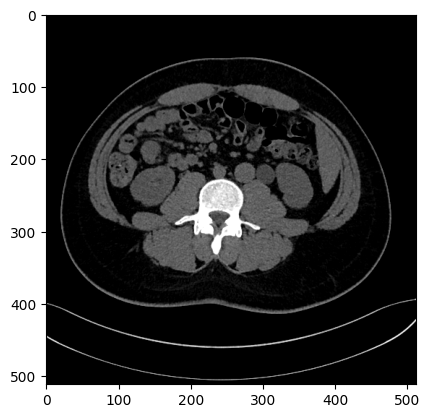

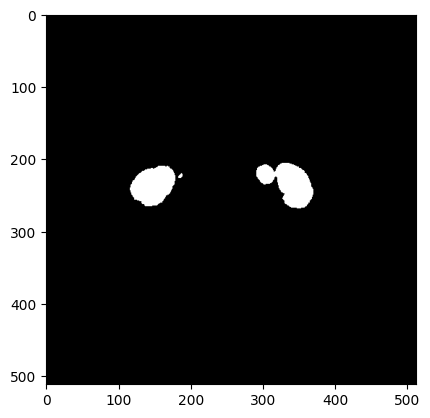

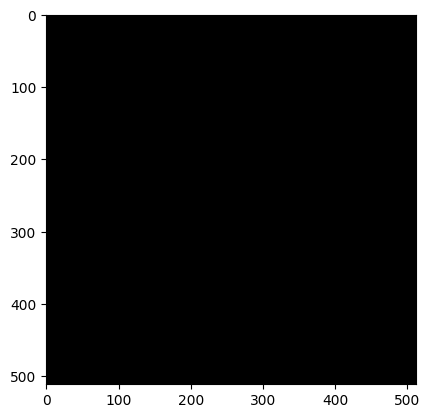

In [296]:
plt.imshow(sample_data[0][0][:,:,130].cpu().detach().numpy(), cmap = "gray")
plt.show()
plt.imshow(mask[0][0][:,:,130], cmap = "gray")
plt.show()
plt.imshow(predicted_mask[0][0][:,:,130].cpu().detach().numpy(), cmap =  "gray")
plt.show()

In [159]:
val_dataset = Dataset(val, transform = val_transforms)

val_loader = DataLoader(val_dataset, batch_size=1, shuffle = False, num_workers=4)

In [ ]:
# for val_data in val_loader:
            
           
#     val_inputs, val_labels = val_data["image"], val_data["label"]
#     print(val_inputs.shape, val_labels.shape)
#     break 

In [ ]:
#Validation dataset and data loader
base_dir = "/mnt/storage/charan/npz_data/"
dataset = Dataset(base_dir= base_dir, split='val', domain_list= "KiTS",
                    transforms=tfs.Compose([
                        CreateOnehotLabel(num_classes=2),
                        ToTensor()
                    ]))
dataloader_val = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=8, pin_memory=True)

In [ ]:
dataloader_val

In [ ]:
#load the trained model

model = Unet2D(num_classes=2, norm='dsbn', num_domains=2)
device = torch.device("cuda:2")
model.load_state_dict(torch.load("best_model_DN.pth")["model_dict"])

# model = nn.DataParallel(model, device_ids=["cuda:0", "cuda:1"])
model.to(device)

In [ ]:
means_list = []
vars_list = []

for i in range(2):
    means, vars = get_bn_statis(model, i)
    means_list.append(means)
    vars_list.append(vars)

In [ ]:
len(means_list), len(vars_list)

In [ ]:
total_dice = 0

model_copy = copy.deepcopy(model)
model_copy.train()   

with torch.no_grad():
    for idx, (batch, id) in enumerate(dataloader_val):
        if idx==0:
            model.train()            
            sample_data = batch['image'].to(device)
            print("shape of the input batch:", sample_data.shape)
            mask = batch['label'].detach().numpy()
            
            dis = 99999999
            best_out = None
            for domain_id in range(2):
                output = model_copy(sample_data, domain_label=domain_id*torch.ones(sample_data.shape[0], dtype=torch.long))
                means, vars = get_bn_statis(model_copy, domain_id)
                new_dis = cal_distance(means, means_list[domain_id], vars, vars_list[domain_id])
                if new_dis < dis:
                    selected_domain = domain_id
                    dis = new_dis

            model_copy = copy.deepcopy(model)

            #this can be replicated with monai slice inferer
            model.eval()
            output_selected = model(sample_data,  domain_label=selected_domain*torch.ones(sample_data.shape[0], dtype=torch.long) )
            output = output_selected

            pred_y = output.cpu().detach().numpy()

            pred_y = np.argmax(pred_y, axis=1)
            if idx==0:
                break
    

In [ ]:
input_data = sample_data.cpu().detach().numpy()


In [ ]:
input_data.shape

In [ ]:
fig,axes = plt.subplots(5,3,dpi=300)
axes = axes.flatten()

i=0
j=10
while i < axes.shape[0]: 

    axes[i].imshow(input_data[j][0], cmap = "gray") 
    axes[i].axis('off')
    i+=1
    axes[i].imshow(pred_y[j,:,:], cmap = "gray") 
    axes[i].axis('off')
    i+=1
    axes[i].imshow(mask[j,:,:], cmap = "gray") 
    axes[i].axis('off')
    i+=1
    j+=1

#indices = bacth 1 - 5, 8 , 13, 14, batch 2 - 0, 6, 7 , 9 , 10, 11, 13, 14, 15 batch 3 - 0, 11, 12, 14

In [ ]:
fig,axes = plt.subplots(5,3,dpi=300)
axes = axes.flatten()

i=0
j=10
while i < axes.shape[0]: 

    axes[i].imshow(input_data[j][0], cmap = "gray") 
    axes[i].axis('off')
    i+=1
    axes[i].imshow(pred_y[j,:,:], cmap = "gray") 
    axes[i].axis('off')
    i+=1
    axes[i].imshow(mask[j,:,:], cmap = "gray") 
    axes[i].axis('off')
    i+=1
    j+=1

#indices = bacth 1 - 5, 8 , 13, 14, batch 2 - 0, 6, 7 , 9 , 10, 11, 13, 14, 15 batch 3 - 0, 11, 12, 14

In [ ]:
#indices = bacth 1 - 5, 8 , 13, 14, batch 2 - 0, 6, 7 , 9 , 10, 11, 13, 14, 15 batch 3 - 0, 11, 12, 14

print("Original Image slice")
plt.imshow(input_data[14][0], cmap = "gray")
plt.axis("off")
plt.show()
print("Model's segmentation")
plt.imshow(pred_y[14,:,:], cmap = "gray")
plt.axis("off")
plt.show()
print("Ground truth mask")
plt.imshow(mask[14,:,:], cmap = "gray")
plt.axis("off")
plt.show()

In [ ]:
/mnt/storage/ramon_data_curations/tutorials/segmentation_tutorial/step1_play_w_bezier_curve.ipynb

In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
try:
    from scipy.special import comb
except:
    from scipy.misc import comb


def bernstein_poly(i, n, t):
    """
     The Bernstein polynomial of n, i as a function of t
    """
    return comb(n, i) * ( t**(n-i) ) * (1 - t)**i



def bezier_curve(points, nTimes=1000):
    """
       Given a set of control points, return the
       bezier curve defined by the control points.
       Control points should be a list of lists, or list of tuples
       such as [ [1,1], 
                 [2,3], 
                 [4,5], ..[Xn, Yn] ]
        nTimes is the number of time steps, defaults to 1000
        See http://processingjs.nihongoresources.com/bezierinfo/
    """

    nPoints = len(points)
    xPoints = np.array([p[0] for p in points])
    yPoints = np.array([p[1] for p in points])

    t = np.linspace(0.0, 1.0, nTimes)

    polynomial_array = np.array([bernstein_poly(i, nPoints-1, t) for i in range(0, nPoints)])

    xvals = np.dot(xPoints, polynomial_array)
    yvals = np.dot(yPoints, polynomial_array)

    return xvals, yvals


# points = [[-1,-1],[-1,-1],[1,1],[1,1]]
# bezier_curve(points, nTimes=4)


In [ ]:
def nonlinear_transformation(x, prob=0.5):
    if random.random() >= prob:
        return x
    points = [[0, 0], [random.random(), random.random()], [random.random(), random.random()], [1, 1]]
    xvals, yvals = bezier_curve(points, nTimes=100000)
    if random.random() < 0.5:
        # Half change to get flip
        xvals = np.sort(xvals)
    else:
        xvals, yvals = np.sort(xvals), np.sort(yvals)
    nonlinear_x = np.interp(x, xvals, yvals)
    return nonlinear_x